## Community Detection with Network Embedding

This notebook aims at detecting communities of a network by 
1. applying network embedding on network to get vectorized representation of a graph,
2. apply clustering algorithm on these embedding to find communities,
3. and then applying dimensionality reduction tool, UMAP to visualize the cluster.

### Data
1. [Les Misérables Network](http://konect.uni-koblenz.de/test/networks/moreno_lesmis).


### Reference
1. node2vec: Scalable Feature Learning for Networks, Aditya Grover, Jure Leskovec. 2016. [Paper](https://arxiv.org/pdf/1607.00653.pdf), [Code](https://github.com/aditya-grover/node2vec).
2. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, Leland McInnes, John Healy, James Melville, 2018. [Paper](https://arxiv.org/pdf/1802.03426.pdf). [Code](https://github.com/lmcinnes/umap). 
3. UMAP Documentation, Leland McInnes. [Doc](https://media.readthedocs.org/pdf/umap-learn/latest/umap-learn.pdf).

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
import umap

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 8)
sns.set_palette(palette)

In [2]:
import random
random.seed(246)        # or any integer
import numpy
numpy.random.seed(4812)

In [3]:
def get_sub_plot(width = 10, height = 6, label_font_size = 14, tick_font_size = 13):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax.tick_params(labelsize = tick_font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)
    return ax

### Exploratory Data Analysis on the Network Data

In [4]:
# Inspect the graph
!ls graph/*

graph/karate.edgelist         graph/les_miserables.edgelist


In [5]:
# Use les_miserables as graph data
graph_file = 'graph/les_miserables.edgelist'

In [6]:
# load data and report basic info
G = nx.read_edgelist(graph_file, nodetype = int, data=(('weight', float),))
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 77
Number of edges: 254
Average degree:   6.5974


### Generate Network Embedding with Node2vec

In [7]:
graph_file

'graph/les_miserables.edgelist'

In [8]:
# Call node2vec package to generate embedding
!python node2vec/src/main.py --input graph/les_miserables.edgelist --output emb/les_miserables.emb --dimensions 16 --p 1 --q 0.5 --walk-length 7 --iter 200 --weighted

[Starting Random Walks]
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10

[Starting Learning Embeddings]
Saved Embedding at emb/les_miserables.emb



### Applying Clustering Algorithms for Community Detection

In [9]:
emb_file = 'emb/les_miserables.emb'

In [10]:
# load the embedding in numpy array
embs = np.loadtxt(emb_file, delimiter = " ", skiprows = 1)

In [11]:
# skip the first column since it's the node id
node_ids = [int(emb[0]) for emb in embs]
print(node_ids)

[11, 2, 56, 26, 59, 27, 49, 63, 28, 24, 65, 60, 4, 3, 50, 25, 52, 64, 66, 29, 70, 62, 36, 18, 19, 69, 20, 21, 23, 71, 42, 17, 30, 22, 58, 35, 37, 61, 39, 38, 76, 32, 67, 75, 74, 47, 72, 9, 55, 40, 77, 45, 10, 46, 44, 43, 31, 48, 34, 53, 6, 73, 7, 57, 68, 13, 1, 8, 51, 5, 16, 15, 54, 33, 41, 12, 14]


In [12]:
embs = np.array([emb[1:] for emb in embs])
print(embs)

[[ 0.0435967  -0.25456798  0.5205234  ...  0.62822944  0.01757852
  -0.26488674]
 [-0.37403914  0.818308    0.48558623 ...  0.5111419  -0.80856127
  -0.09572712]
 [ 0.05063136 -0.6151746   0.67042106 ...  0.12665151 -0.11806435
  -0.2502267 ]
 ...
 [-0.40731573 -0.56561816  0.33539143 ... -0.96927774 -0.22907783
  -0.16396947]
 [-0.1305599  -0.02021191  1.4815074  ...  0.3213249  -1.2362156
  -0.33379677]
 [ 0.8612385   0.20088528 -0.09251707 ...  0.37823537 -0.18499018
   0.3942587 ]]


In [13]:
kmeans = KMeans(n_clusters = 6, n_init = 50, max_iter = 500, verbose = 0, random_state = 42).fit(embs)
print(kmeans.labels_)

[5 0 3 5 2 3 2 2 5 4 2 2 0 0 3 5 3 2 2 3 5 2 1 4 4 5 4 4 4 5 5 4 1 4 2 1 1
 2 1 1 5 5 2 2 2 2 5 0 3 3 2 3 0 3 5 5 5 2 5 3 0 5 0 3 2 1 0 0 3 0 1 3 3 1
 5 5 1]


In [14]:
df_emb_clulstered = pd.DataFrame({'node_id' : node_ids, 'emb': list(embs), 'cluster' : kmeans.labels_})
df_emb_clulstered = df_emb_clulstered[['node_id', 'emb', 'cluster']]

In [15]:
df_emb_clulstered.sort_values(by = ['node_id']).head(20)

,node_id,emb,cluster
66,1,"[4.5702545e-06, 1.05354, 0.40854335, -1.013794...",0
1,2,"[-0.37403914, 0.818308, 0.48558623, -0.7431226...",0
13,3,"[-0.70922536, 0.72719216, 0.6237742, -0.750795...",0
12,4,"[-0.6227288, 0.64968413, 0.70289475, -0.946430...",0
69,5,"[0.36907417, 0.78529865, -0.64618146, -0.41296...",0
60,6,"[-0.3662014, 0.5221467, 0.567464, -0.3751505, ...",0
62,7,"[-0.49809998, 0.27200454, 0.11891116, -1.13420...",0
67,8,"[-0.8232415, -0.7086475, 1.115677, -0.79557574...",0
47,9,"[-1.0903728, 0.66591835, 0.76524454, -0.157644...",0
52,10,"[-0.6654444, 1.0139991, 0.984963, -0.6859543, ...",0


### Visualize Embedding with Dimensionality Reduction

In [16]:
# Apply UMAP to reduce the embedding into two-dim format.
reducer = umap.UMAP(n_components = 2,
                    min_dist = 0.99,
                    spread = 0.99,
                    metric = 'euclidean',
                    local_connectivity = 5,
                    n_neighbors = 10,
                    random_state = 42,
                    n_epochs = 1000,
                    verbose = True)

reduced_embs = reducer.fit_transform(embs)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=5, metric='euclidean',
   metric_kwds=None, min_dist=0.99, n_components=2, n_epochs=1000,
   n_neighbors=10, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=0.99,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs


Now the data is being reduced into two-dim format.

Let's plot the reduced data:

In [17]:
# get dataframe with the reduced embedding
df_emb_clulstered['reduced_x'] = reduced_embs[:, 0]
df_emb_clulstered['reduced_y'] = reduced_embs[:, 1]
df_emb_clulstered.head()

,node_id,emb,cluster,reduced_x,reduced_y
0,11,"[0.043596696, -0.25456798, 0.5205234, -0.45326...",5,15.043605,-3.337033
1,2,"[-0.37403914, 0.818308, 0.48558623, -0.7431226...",0,7.325633,-8.770506
2,56,"[0.050631355, -0.6151746, 0.67042106, -0.71515...",3,17.280590,-3.879903
3,26,"[-0.15959041, -0.06877253, 0.8772947, 0.183427...",5,16.332069,-1.005866
4,59,"[0.096379615, -0.476913, 0.23578438, -0.687450...",2,20.124603,-4.130173


In [18]:
node2posMap = {}

for index, row in df_emb_clulstered.iterrows():
    node2posMap[row['node_id']] = [row['reduced_x'], row['reduced_y']]

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


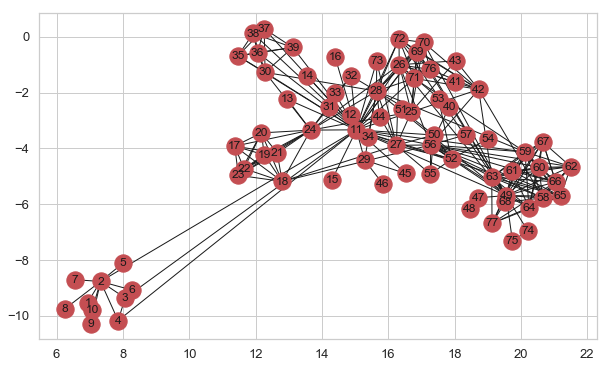

In [19]:
ax = get_sub_plot()
nx.draw_networkx(G, pos = node2posMap, ax = ax)

Let's also plot the graph together with its clusters, denoted by different node colors.

In [20]:
node2clusterMap = {}

for index, row in df_emb_clulstered.iterrows():
    node2clusterMap[row['node_id']] = row['cluster']

clusters = [node2clusterMap[node] for node in G.nodes()]

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


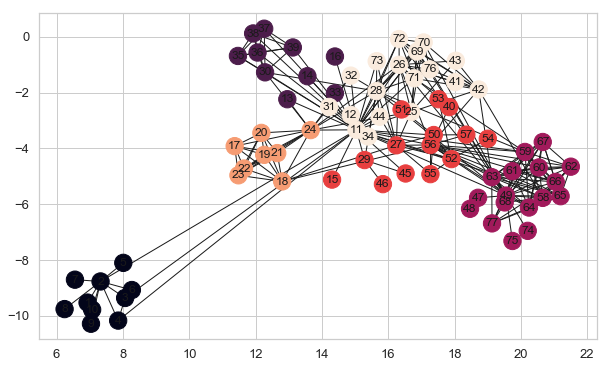

In [21]:
ax = get_sub_plot()
nx.draw_networkx(G, pos = node2posMap, node_color = clusters, ax = ax)

Yes we can clear see the communities now.